


# **Tri Vu**

<center>
<font size=10> <b> BME 848 - Ultrasound Lab Report </font>
    </center>

# Effect of Harmonic Imaging
<font size=5> Turning on tissue harmonic imaging (THI) by pushing the THI button, we can see that the image quality becomes significantly better with higher contrast and sharper edges. However, the frame rate is doubled. The possible reason is that two pulses are employed to generate harmonic images, either by pulse inversion or amplitude modulation. </font>

# Effect of Transmit Focal Zone
<font size=5> When adjusting the focal zone from 2 cm to 9 cm, it is obvious that structures at regions up to 9 cm can now be visualized. However, the contrast deteriorate significantly at lower depth (~7cm) due to acoustic attenuation. </font>

# Effect of Dynamic Range
<font size=5> Dynamic range indicates the intensity distribution of the pixels. By increasing the range, the image will appear to be more gray. At lower dynamic range, more pixels will appear to be bright, making the image mostly black-and-white at 30 dB. 2D gain on the other hand boosts the brightness on all the pixels without saturating the image, while TGC adjusts the visibility at different depths. </font>

# Effect of Focal Zones
<font size=5> With increasing number of focal zones, we have better image quality with more uniform contrast and resolution at multiple axial regions. The tradeoff is again the decreased frame rate because more focused transmit are sent for more focal zones. In details, with 1, 2 and 3 focal zones, the frame rate are 26, 15 and 11 Hz respectively. </font>

# Effect of Transmit Frequency
<font size=5> By changing the frequency to 4 MHz, we can reveal the structures at deeper region due to frequency-dependent attenuation. It comes the cost of worse spatial resolution, because both lateral and axial resolution are directly proportional to transmit wavelength.</font>

# Elasticity Imaging Modes
<font size=5> Elasticity imaging have three main modes: virtual touch imaging, virtual touch quantification and virtual touch IQ. In virtual touch. Virtual touch imaging only provides a gray-scale image of stiffness. Virtual touch quantification shows the relative shear wave speed (m/s) at the region of interest, and virtual touch IQ provides a 2D map of shear wave speed (m/s) over an area. </font>

# Doppler Imaging Modes
<font size=5> In pulsed doppler mode, we look at the velocity spectrum with direction along a small region with very high frame rate. Thus, it is the most sensitive to detect turbulence. Color doppler, on the other hand, provides 3D map of flow velocity, encoded with different color for flow direction. Power doppler is similar to color doppler but it only displays the magnitude of flow without any information about velocity and direction. M-mode imaging does not provide flow information but a single A-line over time. It is suitable for determining the heart rate and heart chamber dimensions.</font>

# Coding Section

In [1]:
import scipy.io as sio
from scipy.signal import hilbert, butter, lfilter

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import axes as ax

### Input and Config

In [3]:
# Note: all distance units are in [m]
ele_spacing = 0.201e-3 # Transducer element spacing
ele_num = 192 # Number of elements
beam_num = 41 # Number of lines (beams)
beam_spacing = 0.151e-3 # Beam spacing
fs = 40e6 # Sampling frequency
sos = 1452 # Speed of sound
focus = 2.5e-2 # Beamforming fixed focus
fnum = 2 # F number
depth = 3e-2 # Imaging depth
fbw = 0.55 # Fractional bandwidth
starting_sample = 10 # Starting index of t = 0
x_comp = 0.6 # Compression value

In [4]:
# Pre-processing calculation
aperture = depth/fnum
ele_num_apert = round(aperture/ele_spacing) # Number of elements within the receiving aperture
ele_num_apert_half = round(ele_num_apert/2)
fc = fs/8 # center frequency
low_f = fc-fbw*fc/2 # low cutoff frequency
high_f = fc+fbw*fc/2 # high cutoff frequency

### Utility functions for each steps in beamforming

In [5]:
def getDelays(focus):
    """ Calculate how many pixels we need to delay for each channel and beam based on input focus """
    
    to_delay = np.ones([ele_num, beam_num])
    for i in range(ele_num):
        for j in range(beam_num):
            to_delay[i,j] = round(np.sqrt((ele_lat[i]-beam_lat[j])**2+focus**2)/sos*fs)

    to_delay = to_delay - to_delay.min()
    to_delay = to_delay.astype(int)
    
    return to_delay

In [6]:
def dasApod(raw, apod, to_delay):
    """ Delayed, apodized and summed rfdata to form A-line signal for all the beams """
    
    raw_delayed = np.zeros(raw.shape)
    das = np.zeros([raw.shape[0], raw.shape[2]])
    for j in range(beam_num):
        for i in range(ele_num):
            # Apply calculated pixels-to-delay to each channel for each beam
            raw_delayed[:raw_delayed.shape[0]-to_delay[i,j],i,
                                  j] = raw[to_delay[i,j]:to_delay[i,j]+raw.shape[0],i,j]
        
        curr_center = round(beam_lat[j]/ele_spacing + ele_num/2) # Get the current center element of j-th beam
        to_sum = raw_delayed[:,
                        int(curr_center-ele_num_apert_half+1):int(curr_center+ele_num_apert_half),j] # Extract
        # the rfdata within the aperture to be apodized and summed
        
        das[:,j] = np.dot(to_sum,apod) # Apodized and summed = matrix multiplication
    
    return das

In [7]:
def bandpassFilter(data):
    """ Bandpass filter based on 3rd-order Butterworth filter on RF channel data """
    
    bp = np.zeros(data.shape)
    b, a = butter(5, [low_f, high_f], btype='bandpass', fs=fs)
    for j in range(beam_num):
        bp[:,j] = lfilter(b, a, data[:,j])
        
    return bp

In [8]:
def tgc(data):
    """ Apply time-gain compensation (TGC) based on absorption attenuation (losses in tissue)
        For more information, refer to page 83 Szabo """
    
    loss = np.exp(8.69*ax_length)
    output = np.zeros(data.shape)
    for i in range(data.shape[0]):
        output[i,:] = data[i,:]*loss[i]
        
    return output

In [9]:
def envelopeDetect(a):
    """ Hilbert transformation for envelope detection of RF channel data """
    
    b = np.zeros(a.shape)
    for j in range(beam_num):
        b[:,j] = np.abs(hilbert(a[:,j]))
        
    return b

In [10]:
def imgComp(data, x_comp=0.6):
    """ Image compression based on the formula in slide 71, RIP2020-Ultrasound """
    compressed_img = np.exp(x_comp*np.log(data))
    
    return compressed_img

In [11]:
def constructPlot(data, title, fsize=(6,10), cmax=None):
    """ Construct subplots based on the stacked matrices and its corresponded label 
        NOTE: title[0] is the main title. title[i] is the """
    fig = plt.figure(figsize=fsize)
    for i in range(data.shape[2]):
        ax = fig.add_subplot(1,data.shape[2],i+1)
        plt.imshow(data[:,:,i], extent=[beam_lat[0]*1e3,beam_lat[-1]*1e3,ax_length_mm[-1],ax_length_mm[0]], 
                   interpolation='nearest', aspect='auto', cmap='gray')
        if cmax is not None:
            plt.clim(data[:,:,i].min(), cmax)
        plt.ylim(ax_length_mm[-1],5)
        if i == 0:
            plt.ylabel('Axial Direction (mm)', fontsize=15)
        plt.xlabel('Lateral Direction (mm)', fontsize=15)
        ax.set_title(title[i+1], fontsize=15)  
    
    plt.suptitle(title[0], fontsize=20)
    plt.show()

### Data Input and Setup

In [12]:
# Load data. readBinData was already called and the data is already saved in mat files for being imported here
planewave_raw = sio.loadmat('imageData_PlaneWave.mat')
planewave_raw = planewave_raw['plane_wave']
planewave_raw = planewave_raw[starting_sample:,:,:]
focused_raw = sio.loadmat('imageData_Focused.mat')
focused_raw = focused_raw['focused']
focused_raw = focused_raw[starting_sample:,:,:]

In [13]:
# Setup element and beam positions
beam_lat = np.linspace(-beam_spacing*np.floor(beam_num/2), beam_spacing*np.floor(beam_num/2), beam_num)
ele_lat = np.linspace(-ele_spacing*np.floor(ele_num/2), ele_spacing*np.floor(ele_num/2), ele_num)
ax_length = np.linspace(0, planewave_raw.shape[0]/fs*sos/2, planewave_raw.shape[0])
ax_length_mm = ax_length*1e3 # in mm for better display in plots

In [14]:
# Setup apodization profiles
rect_apod = np.ones(ele_num_apert) # Uniform apodization
cos_apod = np.cos(np.linspace(-np.pi/2,np.pi/2,ele_num_apert)) # Cosine apod
raised_cos_apod = cos_apod+1 # Raised cosine apod
triangle_apod = np.linspace(0.1,1.9,ele_num_apert) # Triangle apod
triangle_apod[triangle_apod>1.001] = np.flip(triangle_apod[triangle_apod<0.999])

# Question 1

# (a) Fixed Received Focus Beamformed Image

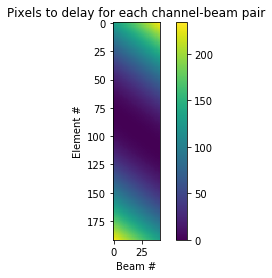

In [15]:
# Calculate how many pixels we need to delay for each channel and beam

to_delay = getDelays(focus)

plt.imshow(to_delay)
plt.colorbar()
plt.title('Pixels to delay for each channel-beam pair')
plt.xlabel('Beam #')
plt.ylabel('Element #')
plt.show()

In [16]:
planewave_das = dasApod(planewave_raw, cos_apod, to_delay)
focused_das = dasApod(focused_raw, cos_apod, to_delay)

In [17]:
# Apply bandpass filter
planewave_das_bp = bandpassFilter(planewave_das)
focused_das_bp = bandpassFilter(focused_das)

In [18]:
# Apply envelope detection
planewave_das_env = envelopeDetect(planewave_das_bp)
focused_das_env = envelopeDetect(focused_das_bp)

In [19]:
# Apply TGC
planewave_env_tgc = tgc(planewave_das_env)
focused_env_tgc = tgc(focused_das_env)

In [20]:
# Apply image compression
planewave_comp = imgComp(planewave_env_tgc)
focused_comp = imgComp(focused_env_tgc)

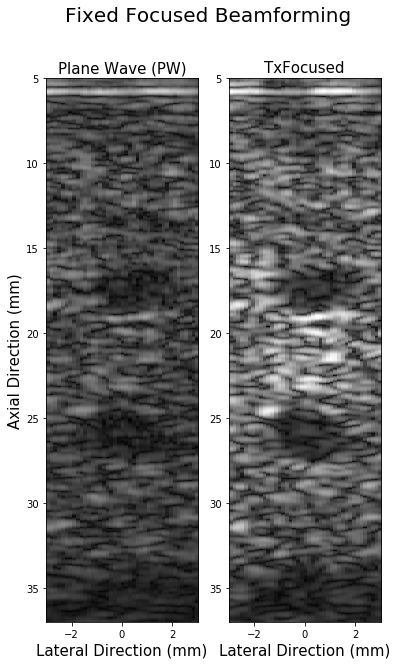

In [21]:
# Plot images
matrix_1a = np.stack((planewave_comp, focused_comp),axis=-1)
label_1a = ['Fixed Focused Beamforming', 'Plane Wave (PW)', 'TxFocused']
constructPlot(matrix_1a, label_1a, cmax=80)

## Discussion

<font size = "5"> 
For fixed focused beamforming, both images observe the best resolution (based on speckle size) and constrast at around the focus (~20-27 mm). However, the contrast at this focal region in transmit-focused image is much brighter than that in plane-wave image, showing the lesions at 17- and 26-mm more clearly. </font>

# (b) Dynamic Focused Beamforming

In [22]:
def beamforming(data, focus, apod, x_comp=0.6):
    for i in range(len(focus)):
        # Steps to perform regular beamforming
        to_delay = getDelays(focus[i])
        das = dasApod(data, apod, to_delay)
        das_bp = bandpassFilter(das)
        das_env = envelopeDetect(das_bp)
        das_env_tgc = tgc(das_env)
        das_tgc_comp = imgComp(das_env_tgc, x_comp)
        
        # Calculate the range for each region of focus
        if len(focus) == 1:
            start_index = 0
            end_index = das.shape[0]
            output = np.zeros(das_tgc_comp.shape)
        else:
            if i == 0:
                start_index = 0
                end_index = round((focus[i]+(focus[i+1]-focus[i])/2)/sos*fs*2)
                output = np.zeros(das_tgc_comp.shape)
            elif i == len(focus)-1: 
                start_index = end_index
                end_index = das.shape[0]
            else:
                start_index = end_index
                end_index = round((focus[i]+(focus[i+1]-focus[i])/2)/sos*fs*2)
            
        # Assign the corresponded focused region to the beamformed output
        output[start_index:end_index,:] = das_tgc_comp[start_index:end_index,:]
        
    return output

In [23]:
# Set focal positions
dyn_focus = [0.7e-2, 1.5e-2, 2e-2, 2.5e-2, 3e-2] # Focuses for dynamic receive (axial depth (m))

In [24]:
# Perform dynamic focused beamforming
planewave_dynamic = beamforming(planewave_raw, dyn_focus, rect_apod)
focused_dynamic = beamforming(focused_raw, dyn_focus, rect_apod)

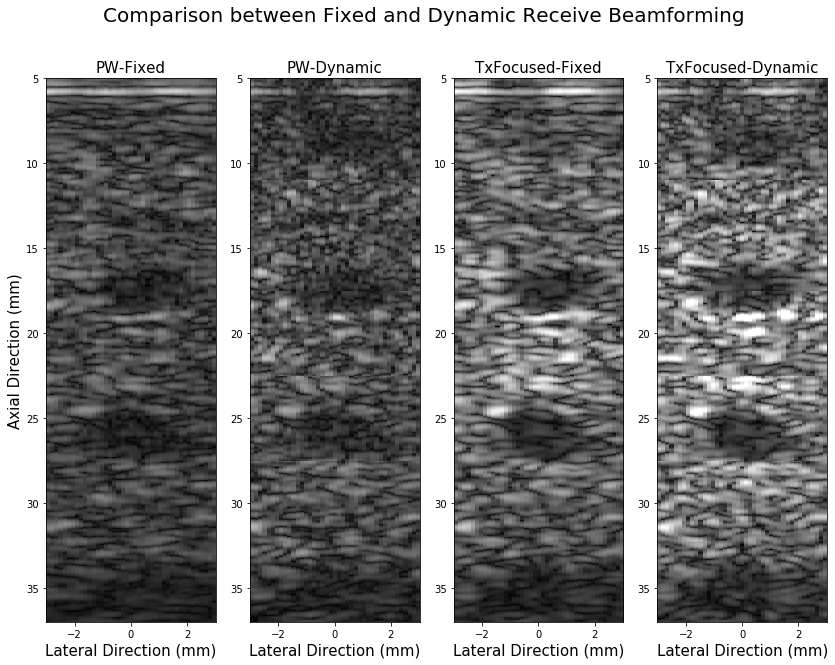

In [25]:
# Plot images
matrix_1b = np.stack((planewave_comp, planewave_dynamic, focused_comp, focused_dynamic),axis=-1)
label_1b = ['Comparison between Fixed and Dynamic Receive Beamforming', 
            'PW-Fixed', 'PW-Dynamic', 'TxFocused-Fixed', 'TxFocused-Dynamic']
constructPlot(matrix_1b, label_1b, fsize=(14,10), cmax=80)

## Discussion

<font size = "5"> 
For both plane-wave and transmit-focused cases, dynamic receive beamforming helps us maintain a more uniform resolution and increased contrast throughout the axial depth. It helps us distinguish lesions more clearly, especially for lesions at 7- and 35-mm depth which is initially invisible in fixed receive beamformed images. Thanks to dynamic receive, image quality outside the focal region is significantly improved. </font>

# (c) Apodized Beamformed Images

In [26]:
# Apply cosine apod to fixed focused beamforming
planewave_fixed_cos = beamforming(planewave_raw, np.asarray([focus]), cos_apod)
focused_fixed_cos = beamforming(focused_raw, np.asarray([focus]), cos_apod)

In [27]:
# Apply cosine apod to dynamic focused beamforming
planewave_dynamic_cos = beamforming(planewave_raw, dyn_focus, cos_apod)
focused_dynamic_cos = beamforming(focused_raw, dyn_focus, cos_apod)

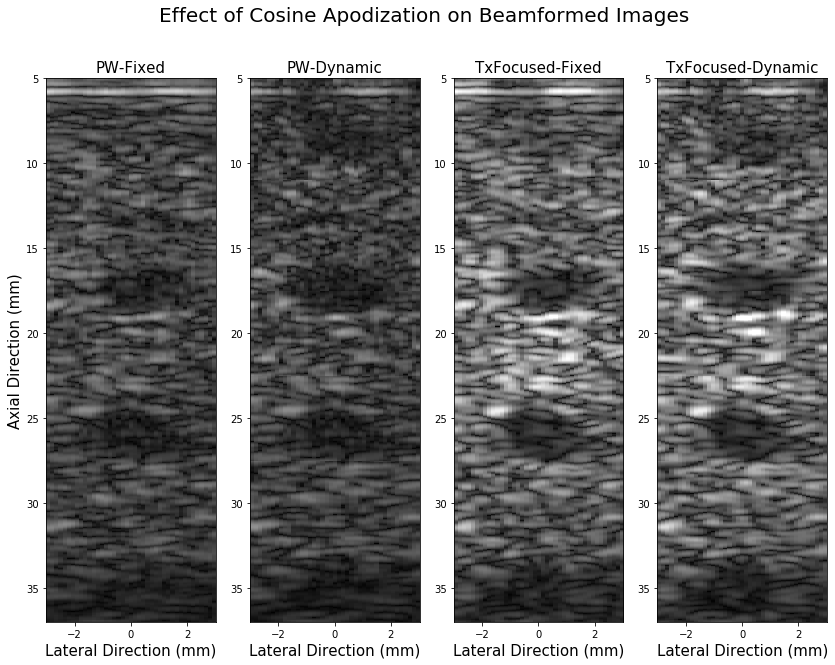

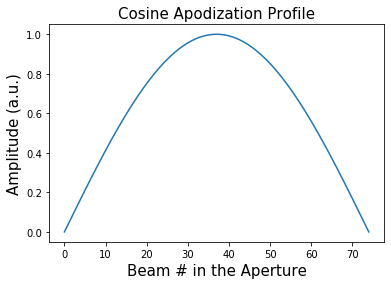

In [28]:
matrix_1c = np.stack((planewave_fixed_cos, planewave_dynamic_cos, focused_fixed_cos, focused_dynamic_cos), axis=-1)
label_1c = ['Effect of Cosine Apodization on Beamformed Images',
           'PW-Fixed',
           'PW-Dynamic',
           'TxFocused-Fixed',
           'TxFocused-Dynamic']
constructPlot(matrix_1c, label_1c, fsize=(14,10), cmax=80)

plt.plot(cos_apod)
plt.title('Cosine Apodization Profile', fontsize=15)
plt.ylabel('Amplitude (a.u.)', fontsize=15)
plt.xlabel('Beam # in the Aperture', fontsize=15)
plt.show()

In [29]:
# Apply raised cosine apod to fixed focused beamforming
planewave_fixed_raisedcos = beamforming(planewave_raw, np.asarray([focus]), raised_cos_apod)
focused_fixed_raisedcos = beamforming(focused_raw, np.asarray([focus]), raised_cos_apod)

In [30]:
# Apply raised cosine apod to dynamic focused beamforming
planewave_dynamic_raisedcos = beamforming(planewave_raw, dyn_focus, raised_cos_apod)
focused_dynamic_raisedcos = beamforming(focused_raw, dyn_focus, raised_cos_apod)

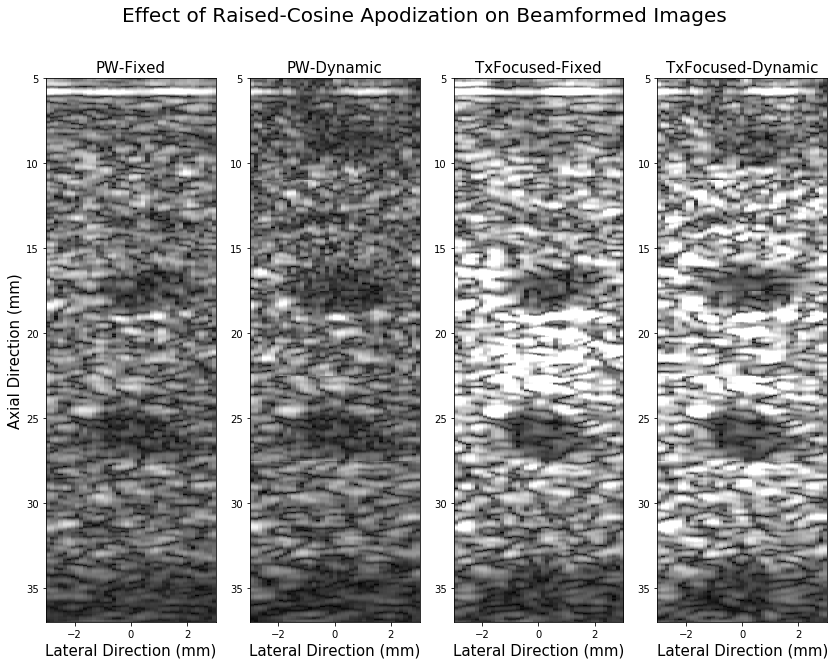

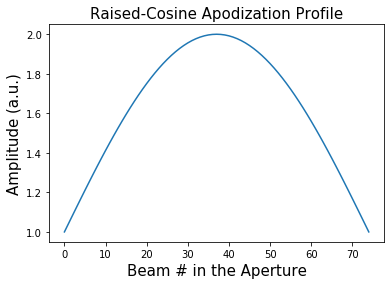

In [31]:
matrix_1c2 = np.stack((planewave_fixed_raisedcos, planewave_dynamic_raisedcos, 
                       focused_fixed_raisedcos, focused_dynamic_raisedcos), axis=-1)
label_1c2 = ['Effect of Raised-Cosine Apodization on Beamformed Images',
           'PW-Fixed',
           'PW-Dynamic',
           'TxFocused-Fixed',
           'TxFocused-Dynamic']
constructPlot(matrix_1c2, label_1c2, fsize=(14,10), cmax=80)

plt.plot(raised_cos_apod)
plt.title('Raised-Cosine Apodization Profile', fontsize=15)
plt.ylabel('Amplitude (a.u.)', fontsize=15)
plt.xlabel('Beam # in the Aperture', fontsize=15)
plt.show()
plt.show()

## Discussion

<font size = "5"> 
It is obvious that with raised-cosine apodization, the contrasts for all the cases increase significantly compared to those with cosine apodization. </font>

# (d) Gray-scale Transfer Curve and Best Configuration

In [32]:
import matplotlib.patches as patches

In [33]:
def calcContrastCNR(data, lesion_rect, bckgrnd_rect):
    """ Calculate contrast and CNR between lesion and background region.
        lesion and bckgrnd input are [y_top_left, x_top_left, height, width] """
    
    bckgrnd = data[bckgrnd_rect[0]:bckgrnd_rect[0]+bckgrnd_rect[2],bckgrnd_rect[1]:bckgrnd_rect[1]+bckgrnd_rect[3]]
    contrast = 0
    cnr = 0
    for i in range(lesion_rect.shape[0]):
        lesion = data[lesion_rect[i,0]:lesion_rect[i,0]+lesion_rect[i,2],lesion_rect[i,1]:lesion_rect[i,1]+lesion_rect[i,3]]
        contrast += np.abs(np.mean(bckgrnd)-np.mean(lesion))/np.mean(bckgrnd)
        cnr += np.abs(np.mean(bckgrnd)-np.mean(lesion))/np.sqrt(np.std(bckgrnd)**2+np.std(lesion)**2)
    
    return round(contrast/lesion_rect.shape[0], 3), round(cnr/lesion_rect.shape[0], 3)

In [34]:
# Initialize multiple compression values to observe their effects on beamformed images
x_comp_arr = [0.2, 0.6, 0.9]

In [35]:
# Setup configurations
transmit = ['Plane-wave', 'Focused']
receive = ['Fixed', 'Dynamic']
apod = ['Cosine', 'Raised-cosine']

In [36]:
# Set lesion and background regions for contrast calculation
lesion_rect = np.array([[1370, 15, 110, 10], [920, 15, 110, 10], [380, 15, 110, 10], [1880, 15, 110, 10]])
bckgrnd_rect = [1100, 15, 110, 10]

In [37]:
# Performing beamforming with all the configurations
count = 0
ctrast = []
ctrast_cfig = []
curr_ctrast = 0
max_ctrast = 0
for i in transmit:
    if i == 'Plane-wave':
        rfdata = planewave_raw
    else: rfdata = focused_raw
    for j in receive:
        if j == 'Fixed':
            focal = np.asarray([focus])
        else: focal = dyn_focus
        for k in apod:
            if k == 'Cosine':
                apodization = cos_apod
            elif k == 'Uniform':
                apodization = rect_apod
            else: apodization = raised_cos_apod
            for l in x_comp_arr:
                recon = beamforming(rfdata, focal, apodization, l)
                curr_ctrast, _ = calcContrastCNR(recon, lesion_rect, bckgrnd_rect)
                if curr_ctrast > max_ctrast:
                    best_recon = recon # Save the beamformed image with the highest contrast
                    max_ctrast = curr_ctrast
                ctrast.append(curr_ctrast)
                ctrast_cfig.append([i, j, k, l])
                print('Beamforming with', i, j, k, str(l))

Beamforming with Plane-wave Fixed Cosine 0.2
Beamforming with Plane-wave Fixed Cosine 0.6
Beamforming with Plane-wave Fixed Cosine 0.9
Beamforming with Plane-wave Fixed Raised-cosine 0.2
Beamforming with Plane-wave Fixed Raised-cosine 0.6
Beamforming with Plane-wave Fixed Raised-cosine 0.9
Beamforming with Plane-wave Dynamic Cosine 0.2
Beamforming with Plane-wave Dynamic Cosine 0.6
Beamforming with Plane-wave Dynamic Cosine 0.9
Beamforming with Plane-wave Dynamic Raised-cosine 0.2
Beamforming with Plane-wave Dynamic Raised-cosine 0.6
Beamforming with Plane-wave Dynamic Raised-cosine 0.9
Beamforming with Focused Fixed Cosine 0.2
Beamforming with Focused Fixed Cosine 0.6
Beamforming with Focused Fixed Cosine 0.9
Beamforming with Focused Fixed Raised-cosine 0.2
Beamforming with Focused Fixed Raised-cosine 0.6
Beamforming with Focused Fixed Raised-cosine 0.9
Beamforming with Focused Dynamic Cosine 0.2
Beamforming with Focused Dynamic Cosine 0.6
Beamforming with Focused Dynamic Cosine 0.9
B

In [38]:
# Display maximum contrast and its corresponded 
best_cfig = ctrast_cfig[np.argmax(ctrast)]
print('Maximum contrast is ', str(np.max(ctrast)), ' with ', best_cfig[0], ' transmit, ',
     best_cfig[1], ' receive, ', best_cfig[2], ' apodization and compression value of ', best_cfig[3])

Maximum contrast is  0.757  with  Focused  transmit,  Fixed  receive,  Raised-cosine  apodization and compression value of  0.9


## Method

<font size = "5"> 
For this question, we choose contrast as the metrics for lesion conspicuity (LC). To determine which configuration gives the best LC, we calculate the mean of four contrasts for each lesion (red rectangles) with the background (yellow rectangle). The contrast is measured by the following formula:
    \begin{equation*}
    contrast = \frac{\mid{\mu_{background}-\mu_{lesion}}\mid}{\mu_{background}}
    \end{equation*}</font>

## Discussion

<font size=5>
From the result, surprisingly, dynamic receive does not have the best performance compared with fixed receive. As expected, focused transmit with raised-cosine apodization and highest compression value of <b> 0.9 </b> gives the highest contrast of lesions (<b>0.757</b>). </font>

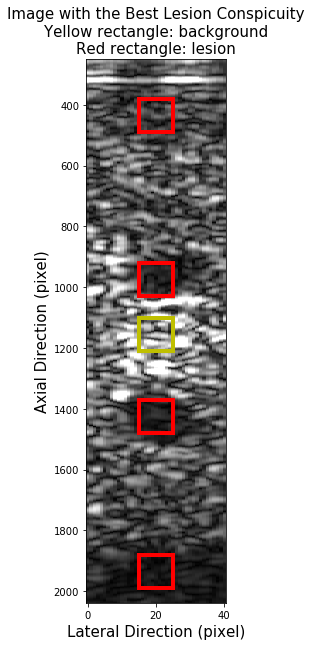

In [39]:
# Calculate contrast between lesion and background
fig, ax = plt.subplots(1,figsize=(2.5,10))
plt.imshow(best_recon, 
                   interpolation='nearest', aspect='auto', cmap='gray')
plt.ylabel('Axial Direction (pixel)', fontsize=15)
plt.xlabel('Lateral Direction (pixel)', fontsize=15)
ax.set_title('Image with the Best Lesion Conspicuity\nYellow rectangle: background\nRed rectangle: lesion', fontsize=15) 
for i in range(lesion_rect.shape[0]):
    ax.add_patch(patches.Rectangle((lesion_rect[i,1], lesion_rect[i,0]), lesion_rect[i,3], lesion_rect[i,2],
                                  linewidth=4, edgecolor='r', facecolor='none'))
ax.add_patch(patches.Rectangle((bckgrnd_rect[1], bckgrnd_rect[0]), bckgrnd_rect[3], bckgrnd_rect[2],
                              linewidth=4, edgecolor='y', facecolor='none'))
plt.clim(best_recon.min(), 1000)
plt.ylim(best_recon.shape[0],250)
plt.show()

# (e) Transmit Beam Profile

In [40]:
# Create new rf data for beam profile
planewave_beam_raw = np.zeros(planewave_raw.shape)
focused_beam_raw = np.zeros(focused_raw.shape)
for i in range(planewave_beam_raw.shape[2]):
    planewave_beam_raw[:,:,i] = planewave_raw[:,:,20]
    focused_beam_raw[:,:,i] = focused_raw[:,:,20]

In [41]:
# Beam profile construction
planewave_beam = beamforming(planewave_beam_raw, np.asarray([focus]), rect_apod)
focused_beam = beamforming(focused_beam_raw, np.asarray([focus]), rect_apod)

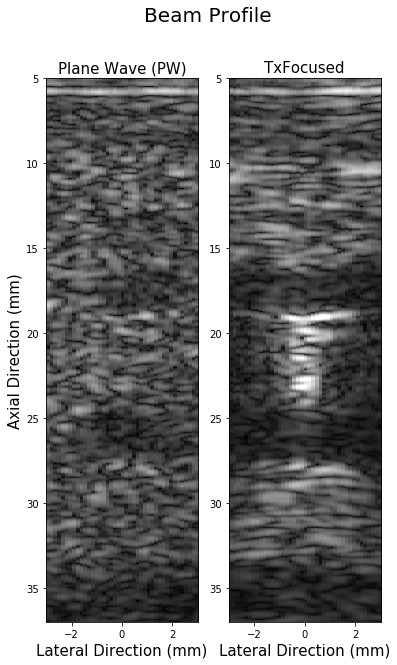

In [42]:
# Plot images
matrix_1e = np.stack((planewave_beam, focused_beam),axis=-1)
label_1e = ['Beam Profile', 'Plane Wave (PW)', 'TxFocused']
constructPlot(matrix_1e, label_1e, cmax = 80)

## Discussion:

<font size = "5"> 
Since its transmit is plane wave, PW image does not show any focused beam profile. On the other hand transmit-focused image clearly displays the beam region. Its focal depth is ~22.5 mm, depth of focus is ~5 mm and beam waist is ~1.5 mm. </font>

# Question 2

In [43]:
# Find best images for plane wave and focused transmit
count = 0
ctrast = []
ctrast_cfig, best_cfig_cases = [], []
curr_ctrast, curr_cnr = 0, 0
max_ctrast, max_cnr = 0, 0
best_recon_cases = np.zeros([recon.shape[0], recon.shape[1], len(transmit)])

for i in transmit:
    if i == 'Plane-wave':
        rfdata = planewave_raw
    else: rfdata = focused_raw
    for j in receive:
        if j == 'Fixed':
            focal = np.asarray([focus])
        else: focal = dyn_focus
        for k in apod:
            if k == 'Cosine':
                apodization = cos_apod
            elif k == 'Uniform':
                apodization = rect_apod
            else: apodization = raised_cos_apod
            for l in x_comp_arr:
                recon = beamforming(rfdata, focal, apodization, l)
                curr_ctrast, _ = calcContrastCNR(recon, lesion_rect, bckgrnd_rect)
                if curr_ctrast > max_ctrast:
                    best_recon = recon # Save the beamformed image with the highest contrast
                    max_ctrast = curr_ctrast
                ctrast.append(curr_ctrast)
                ctrast_cfig.append([i, j, k, l])
    
    best_recon_cases[:,:,count] = best_recon
    best_cfig_cases.append(ctrast_cfig[np.argmax(ctrast)])
    ctrast, cnr = [], []
    ctrast_cfig = []
    curr_ctrast, curr_cnr = 0, 0
    max_ctrast, max_cnr = 0, 0
    count += 1

In [44]:
# Set lesion and background regions for contrast calculation; for this question, we only need the third lesion (at ~2.5 cm)
lesion_rect = np.array([[1370, 15, 110, 10]])
bckgrnd_rect = [1100, 15, 110, 10]

In [45]:
# Calculate contrast and CNR of the 2.5-cm lesion
for i in range(best_recon_cases.shape[2]):
    best_contrast, best_cnr = calcContrastCNR(best_recon_cases[:,:,i], lesion_rect, bckgrnd_rect)
    print('For best case image of ', transmit[i], ' transmit, contrast is ', str(best_contrast), ' and ',
         'CNR is ', str(best_cnr))

For best case image of  Plane-wave  transmit, contrast is  0.651  and  CNR is  1.037
For best case image of  Focused  transmit, contrast is  0.81  and  CNR is  1.9


## Discussion

<font size = "5"> 
For best case image of plane-wave  transmit, contrast is  0.711 and  CNR is 1.597. For focused  transmit, contrast is 0.81 and CNR is 1.9. It is expectable that focused transmit gives both higher contrast and CNR than plane-wave transmit for the lesion closed to the focal region (2.5 cm in depth).</font>

<font size = "5"> 
To calculate the maximum frame rate, first we need to determine the lateral resolution based on the center frequency, aperture size and focus
</font>

In [46]:
D = ele_num*ele_spacing
lat_resolution = sos*focus/(2*D*fc)
print('Lateral resolution: ', str(round(lat_resolution*1e3,3)), ' mm')

Lateral resolution:  0.094  mm


<font size = "5"> According to Nyquist, we have to sample at at least half of the lateral resolution. Such that, we have the total number of lines we need to acquire for whole lateral size: </font>

In [47]:
number_lines = D/(lat_resolution/2)
print('Smallest number of lines to meet Nyquist: ', int(number_lines))

Smallest number of lines to meet Nyquist:  820


<font size = "5"> The time it takes to acquire one line is the travel time of the sound: </font>

In [48]:
t_line = depth/sos*2
print('Travel time for one beam: ', str(round(t_line*1e6,3)), ' us')

Travel time for one beam:  41.322  us


<font size=5> The time it takes to acquire one B-mode image is equal to the product of travel time and number of lines. The frame rate is the reciprocal of this period time. </font>

In [49]:
frame_period = t_line*number_lines
max_frame_rate = 1/frame_period
print('Maximum achievable frame rate: ', str(max_frame_rate), ' fps')

Maximum achievable frame rate:  29.49153808589722  fps


<font size=5> From the above calculation, the maximum achievable frame rate for both cases is <b> <u> 30 fps </u> </b> </font>

# Extra Credit 2

In [62]:
# Create array of speed of sound and perform beamforming with focused transmit, fixed receive and two cosine apodization
vc = np.linspace(1000,2200,100)
ctrast_sos = np.zeros([2, len(vc)])
count = 0
for sos in vc:
    focused_sos_cos = beamforming(focused_raw, np.asarray([focus]), cos_apod)
    focused_sos_rc = beamforming(focused_raw, np.asarray([focus]), raised_cos_apod)
    ctrast_sos[0,count], _ = calcContrastCNR(focused_sos_cos, lesion_rect, bckgrnd_rect) 
    ctrast_sos[1,count], _ = calcContrastCNR(focused_sos_rc, lesion_rect, bckgrnd_rect) 
    count += 1

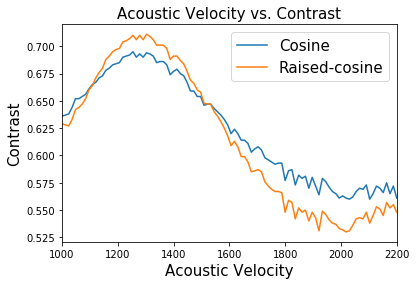

In [65]:
plt.plot(vc, ctrast_sos[0,:], vc, ctrast_sos[1,:])
plt.xlabel('Acoustic Velocity', fontsize=15)
plt.ylabel('Contrast', fontsize=15)
plt.xlim(vc.min(), vc.max())
plt.title('Acoustic Velocity vs. Contrast', fontsize=15)
plt.legend(['Cosine', 'Raised-cosine'], fontsize=15)
plt.show()

In [70]:
print('Maximum contrast for cosine apodization is ', str(np.max(ctrast_sos[0,:])) ,
      'at ', str(round(vc[np.argmax(ctrast_sos[0,:])],1)), ' m/s')
print('Maximum contrast for raised-cosine apodization is ', str(np.max(ctrast_sos[1,:])) ,
      'at ', str(round(vc[np.argmax(ctrast_sos[1,:])],1)), ' m/s')

Maximum contrast for cosine apodization is  0.695 at  1254.5  m/s
Maximum contrast for raised-cosine apodization is  0.711 at  1303.0  m/s


## Discussion

<font size=5> Both apodization profile shows similar trend of contrast versus acoustic velocity, with peaked contrast at ~1200-1400 m/s. The best acoustic velocity for maximizing contrast is ~1280 m/s. </font>